In [1]:
import pandas
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import metrics
from sklearn import model_selection
from sklearn import linear_model as lm
from sklearn import preprocessing
from sklearn import pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegressionCV
from sklearn import neighbors
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn import ensemble
from sklearn import tree
import pickle
from sklearn import decomposition


import os
os.environ['PATH'] = os.environ['PATH'] + ';C:/Program Files (x86)/Graphviz2.38/bin'

#%store -r WORKDIR

#if 'WORKDIR' not in dir():
#WORKDIR = 'C:/Users/cammy/OneDrive/MIT IA/git/projeto_dogs/dogs_brand'

pandas.set_option("display.precision", 2)

input_table = '../../Data/Raw/dogs.parquet'

model_score_file = '../../Data/Modeling/model_scores.parquet'
model_file = '../../Data/Modeling/trained_models.jbl'
save_data =  '../../Data/Modeling/dev_results.jbl'
class_file = '../../Data/Modeling/classes.jbl'


target_variable = ['breed']

# Carga dos Dados

In [2]:
data = pandas.read_parquet(input_table)
print('data shape:', data.shape)

data shape: (521, 4097)


# Treino / Teste

In [3]:
X = data.drop(target_variable, axis = 1).values
Y = data[target_variable].values

In [4]:
classifier_variables = data.drop(target_variable, axis = 1).keys

In [5]:
classes = data.breed.unique()
classes

array(['affenpinscher', 'african', 'airedale'], dtype=object)

In [6]:
Xtrain, Xtest, Ytrain, Ytest = model_selection.train_test_split(X,
                                                                Y,
                                                                test_size=0.2,
                                                                random_state=0,
                                                                stratify=Y)

# Objeto de validacao cruzada
cvfold = model_selection.StratifiedKFold(n_splits = 3, random_state = 0)

C:\Users\cammy\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


# Random Forest

In [41]:
# Configure Pipeline
conf_train_pipe = [
    ('Scaler', StandardScaler()),
    ('PCA', decomposition.PCA(n_components=20)),
    ('Model', ensemble.RandomForestClassifier(n_estimators=10, max_features='sqrt')),
]
model_pipe = pipeline.Pipeline(conf_train_pipe)

# Grid-Search
param_grid = {
    'Model__n_estimators': [10, 30, 40],
    'Model__max_depth': [4, 6, 8],
}
model_pipe = model_selection.GridSearchCV(model_pipe,
                                          param_grid,
                                          scoring=None,
                                          cv=cvfold)

model_pipe.fit(Xtrain, Ytrain.ravel())


decision_threshold = 0.5
Yhat = model_pipe.predict_proba(Xtest)[:,1]
Ypred= Yhat >= decision_threshold

print('Yhat.shape:', Yhat.shape)

Yhat.shape: (105,)


In [43]:
preds = model_pipe.predict(Xtest)
print("Accuracy:", metrics.accuracy_score(Ytest,preds))

Accuracy: 0.6285714285714286


In [44]:
print (metrics.confusion_matrix(Ytest, preds))
print (metrics.classification_report(Ytest, preds))

[[20  5  5]
 [ 0 23 11]
 [ 6 12 23]]
               precision    recall  f1-score   support

affenpinscher       0.77      0.67      0.71        30
      african       0.57      0.68      0.62        34
     airedale       0.59      0.56      0.57        41

     accuracy                           0.63       105
    macro avg       0.64      0.63      0.64       105
 weighted avg       0.64      0.63      0.63       105



In [45]:
preds = model_pipe.predict(Xtrain)
print("Accuracy:", metrics.accuracy_score(Ytrain,preds))

Accuracy: 0.9254807692307693


In [46]:
print (metrics.confusion_matrix(Ytrain, preds))
print (metrics.classification_report(Ytrain, preds))

[[107   6   7]
 [  2 128   5]
 [  3   8 150]]
               precision    recall  f1-score   support

affenpinscher       0.96      0.89      0.92       120
      african       0.90      0.95      0.92       135
     airedale       0.93      0.93      0.93       161

     accuracy                           0.93       416
    macro avg       0.93      0.92      0.93       416
 weighted avg       0.93      0.93      0.93       416



In [47]:
estimatives = model_pipe.predict_proba(Xtest)

# Explicabilidade

In [48]:
model_pipe.best_estimator_.steps

[('Scaler', StandardScaler(copy=True, with_mean=True, with_std=True)),
 ('PCA',
  PCA(copy=True, iterated_power='auto', n_components=20, random_state=None,
      svd_solver='auto', tol=0.0, whiten=False)),
 ('Model',
  RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                         criterion='gini', max_depth=6, max_features='sqrt',
                         max_leaf_nodes=None, max_samples=None,
                         min_impurity_decrease=0.0, min_impurity_split=None,
                         min_samples_leaf=1, min_samples_split=2,
                         min_weight_fraction_leaf=0.0, n_estimators=40,
                         n_jobs=None, oob_score=False, random_state=None,
                         verbose=0, warm_start=False))]

In [14]:
import shap

shap.initjs()
# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn and spark models)
explainer = shap.TreeExplainer(model_pipe.best_estimator_.steps[2][1])

In [15]:
sample_eval = 10

shap_values = explainer.shap_values(Xtrain[sample_eval])
# visualize the first prediction's explanation (use matplotlib=True to avoid Javascript)
#shap.force_plot(explainer.expected_value[1], shap_values[1], Xtrain[sample_eval])
#                feature_names = classifier_variables)

# Distribuição

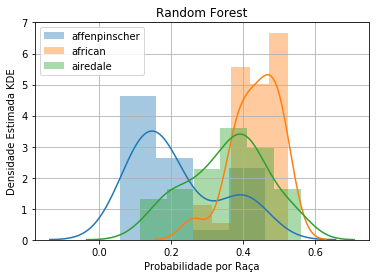

In [49]:
for i in range(len(classes)):
    # 2 Classes case
    sns.distplot(Yhat[Ytest[:,0] == classes[i]], label=classes[i])

plt.title('Random Forest')
plt.ylabel('Densidade Estimada KDE')
plt.xlabel('Probabilidade por Raça')
plt.grid()
plt.legend()

In [17]:
from sklearn.preprocessing import label_binarize
YBin = label_binarize(Y, classes)

In [24]:
YBin

array([[1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       ...,
       [0, 0, 1],
       [0, 0, 1],
       [0, 0, 1]])

In [50]:
n_classes = len(classes)

In [51]:
def plot_multiclass_roc(clf, X_test, y_test, n_classes, figsize=(17, 6)):
    y_score = clf.predict_proba(X_test)

    # structures
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    # calculate dummies once
    y_test_dummies = pandas.get_dummies(y_test.ravel(), drop_first=False).values
    for i in range(n_classes):
        fpr[i], tpr[i], _ = metrics.roc_curve(y_test_dummies[:, i], y_score[:, i])
        roc_auc[i] = metrics.auc(fpr[i], tpr[i])

    # roc for each class
    fig, ax = plt.subplots(figsize=figsize)
    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('Receiver operating characteristic example')
    for i in range(n_classes):
        ax.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f) for label %s' % (roc_auc[i], classes[i]))
    ax.legend(loc="best")
    ax.grid(alpha=.4)
    sns.despine()
    plt.show()

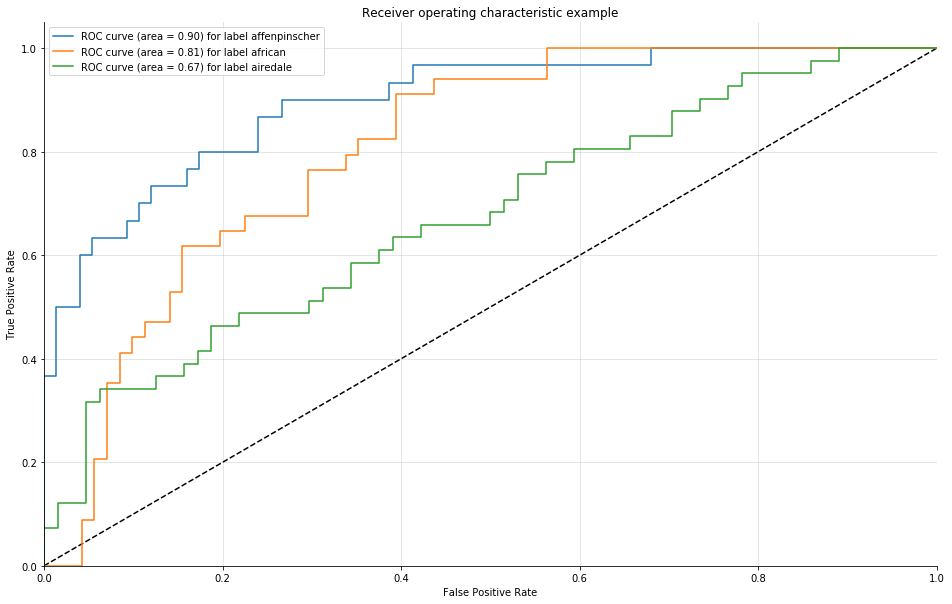

In [52]:
plot_multiclass_roc(model_pipe, Xtest, Ytest, n_classes, figsize=(16, 10))

# Exportar modelo

In [19]:
with open(model_file, 'wb') as fid:
    pickle.dump(model_pipe, fid)

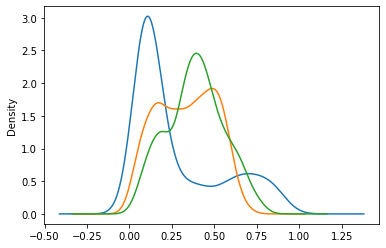

In [20]:
Ydev1 = model_pipe.predict_proba(X)[:,0]
Ydev2 = model_pipe.predict_proba(X)[:,1]
Ydev3 = model_pipe.predict_proba(X)[:,2]
data['estimated_score1'] = Ydev1
data['estimated_score2'] = Ydev2
data['estimated_score3'] = Ydev3
data.to_parquet(save_data)
data.estimated_score1.plot.kde()
data.estimated_score2.plot.kde()
data.estimated_score3.plot.kde()

In [21]:
dfclasses = pandas.DataFrame(classes)
dfclasses.columns = ['raças']
dfclasses.to_parquet(class_file)

In [22]:
dfclasses

,raças
0,affenpinscher
1,african
2,airedale
